In [33]:
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt

In [34]:
X = datasets.fetch_covtype().data[:3000]
y = datasets.fetch_covtype().target[:3000]
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_va, y_train, y_va = train_test_split(X_1, y_1)

print(X_train.shape, y_train.shape)
print(np.unique(y_train))  # 7分类任务

(2025, 54) (2025,)
[1 2 3 4 5 6 7]


In [35]:
enc = OrdinalEncoder()
y_train_enc = enc.fit_transform(y_train.reshape(-1, 1))
y_test_enc = enc.transform(y_test.reshape(-1, 1))
y_va_enc = enc.fit_transform(y_va.reshape(-1, 1))
print(np.unique(y_train_enc))
print(y_train_enc.shape)

[0. 1. 2. 3. 4. 5. 6.]
(2025, 1)


In [36]:
# label.shape = (num_sample, )
train_dataset = lgb.Dataset(data=X_train, label=y_train_enc.reshape(-1, ))
val_dataset = lgb.Dataset(data=X_va, label=y_va_enc.reshape(-1, ))

In [37]:
from sklearn.metrics import log_loss


def my_gbm_loss(y_pred, y_true):
    print(y_true.get_label())
    """lightgbm自定义验证数据集损失函数格式"""
    # 多分类任务中,y_pred先按类进行分组(比如前7个值是y_true[0]的预测值,最后7个值是y_true[-1]的预测值)
    reshape_y_pred = np.transpose(y_pred.reshape(7, -1))  # 这是一个7分类任务
    loss = log_loss(y_true.get_label(), reshape_y_pred)
    # y_true.get_label().shape=(2025, )
    # y_pred.shape=(2025 *7, )
    # reshape_y_pred.shape=(2025, 7)
    # print("y_true.shape:{0},y_pred.shape:{1},reshape_y_pred.shape:{2}".format(y_true.get_label().shape, y_pred.shape, reshape_y_pred.shape))
    # 返回值格式:评估函数的名称(不含空格), 评估结果, 评估结果是否越高越高(比如AUC是越高越好,损失值是越低越好)
    return 'MY_GBM_LOSS', loss, False

In [38]:
evals_result = {}  # 储存评估指标(内置和自定义)结果
re_func = lgb.record_evaluation(eval_result=evals_result)
es_func = lgb.early_stopping(stopping_rounds=200)
le_func = lgb.log_evaluation(100)

params = {"objective": "multiclass",
          "num_class": 7,
          "verbose": -4, "metric": ("multi_logloss",)}

eval_set = [train_dataset, val_dataset]

model = lgb.train(params=params,
                  train_set=train_dataset,
                  # List of data to be evaluated on during training.
                  valid_sets=eval_set,
                  callbacks=[re_func, es_func, le_func],
                  num_boost_round=200,  # 默认num_boost_round=1000
                  feval=my_gbm_loss)  # Customized evaluation function

# 预测结果为概率向量(多分类)
# X_test: numpy array, pandas DataFrame
model.predict(X_test)

[1. 0. 0. ... 4. 4. 1.]
[4. 1. 4. 1. 4. 0. 1. 4. 2. 1. 1. 2. 4. 4. 6. 1. 0. 3. 6. 1. 4. 1. 1. 0.
 1. 0. 4. 3. 3. 5. 5. 4. 4. 1. 1. 4. 0. 1. 4. 4. 4. 3. 4. 6. 2. 5. 0. 0.
 4. 0. 1. 1. 5. 5. 0. 5. 6. 0. 4. 1. 2. 3. 5. 6. 2. 4. 4. 1. 2. 4. 3. 4.
 5. 1. 4. 4. 1. 1. 1. 5. 4. 3. 1. 4. 0. 3. 6. 4. 4. 1. 6. 5. 4. 4. 0. 5.
 0. 4. 4. 4. 5. 1. 0. 0. 4. 5. 1. 1. 1. 4. 4. 4. 4. 1. 2. 1. 4. 0. 1. 4.
 1. 1. 1. 1. 4. 0. 1. 0. 4. 5. 1. 2. 5. 1. 1. 1. 3. 2. 4. 0. 1. 1. 2. 0.
 2. 0. 1. 1. 2. 1. 4. 0. 6. 1. 0. 5. 5. 6. 1. 5. 4. 0. 1. 0. 1. 4. 2. 1.
 4. 2. 5. 3. 0. 4. 1. 1. 5. 1. 3. 1. 5. 0. 3. 4. 0. 0. 0. 1. 1. 4. 4. 1.
 4. 1. 0. 2. 0. 3. 4. 4. 4. 1. 1. 1. 5. 1. 2. 4. 5. 0. 1. 0. 0. 6. 1. 4.
 1. 6. 4. 5. 4. 1. 2. 4. 4. 4. 1. 4. 4. 5. 2. 1. 4. 0. 4. 5. 2. 1. 1. 3.
 1. 5. 1. 3. 0. 4. 2. 4. 4. 4. 2. 1. 6. 1. 4. 4. 4. 1. 6. 0. 0. 6. 1. 2.
 2. 0. 4. 1. 3. 0. 1. 4. 1. 6. 4. 0. 0. 1. 2. 4. 4. 3. 4. 5. 3. 4. 4. 4.
 5. 2. 0. 0. 0. 4. 1. 3. 5. 4. 1. 0. 1. 5. 0. 2. 5. 0. 4. 1. 0. 4. 4. 0.
 1. 4. 1. 4. 1. 5. 4. 5. 2.

array([[1.45308608e-04, 2.45977970e-04, 1.62965048e-09, ...,
        9.99608692e-01, 1.35584838e-08, 2.27986567e-09],
       [3.07782829e-12, 3.68301190e-07, 5.18925862e-12, ...,
        9.99999632e-01, 2.56558884e-12, 2.21556835e-12],
       [4.93925383e-12, 1.38280001e-07, 3.64286367e-11, ...,
        9.99999862e-01, 2.83529076e-12, 2.43202854e-12],
       ...,
       [3.27206204e-09, 5.74506337e-07, 9.99980464e-01, ...,
        3.59106152e-09, 1.84588674e-05, 2.10869066e-10],
       [4.15703714e-09, 1.02962013e-05, 9.02441442e-01, ...,
        3.57094114e-08, 9.75481902e-02, 1.56836527e-09],
       [4.36938951e-07, 3.03193829e-04, 5.53508529e-09, ...,
        9.99696355e-01, 1.97184430e-09, 3.31937771e-09]])

In [39]:
# The best score of fitted model.
model.best_score

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('multi_logloss', 7.467585112233812e-05),
                          ('MY_GBM_LOSS', 7.467585112233243e-05)]),
             'valid_1': OrderedDict([('multi_logloss', 0.7881440931288519),
                          ('MY_GBM_LOSS', 0.7881440931288518)])})

In [40]:
evals_result

{'training': OrderedDict([('multi_logloss',
               [1.3544382985883636,
                1.1598247459025068,
                1.0149481585318998,
                0.8985311625022475,
                0.801719436886292,
                0.7188659079946931,
                0.6495877002152814,
                0.5885452899576346,
                0.5365091233323661,
                0.4925616652421766,
                0.45323480976406305,
                0.41788546569669577,
                0.3870856547735358,
                0.35858774100823493,
                0.3329787415801761,
                0.31098254376328494,
                0.2907173747880593,
                0.27157478330727897,
                0.25366739602664357,
                0.23637476565892251,
                0.22206598884680068,
                0.20769592549422702,
                0.19404028645758642,
                0.18183637262219635,
                0.17098044084055417,
                0.16130045972664295,
        

In [41]:
evals_result['training'].keys()

odict_keys(['multi_logloss', 'MY_GBM_LOSS'])

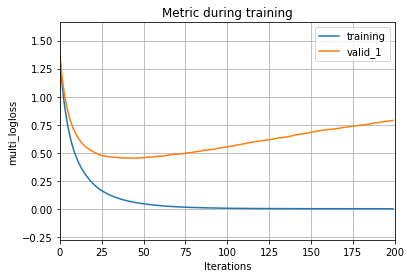

In [42]:
# Plot one metric during training.
ax = lgb.plot_metric(evals_result, metric='multi_logloss')  # multi_logloss指标绘制
plt.show()

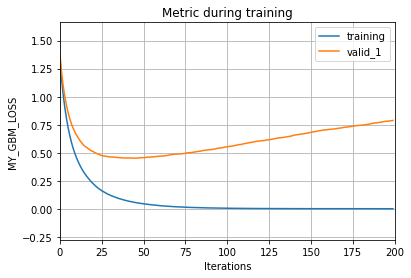

In [43]:
ax1 = lgb.plot_metric(evals_result, metric="MY_GBM_LOSS")  # MY_GBM_LOSS指标绘制
plt.show()

In [44]:
# 特征的相对重要性
model.feature_importance()

array([5510, 2776, 1380, 2796, 2485, 4952, 2569, 2100, 2408, 4985,  277,
          0,  187,   84,  123,   97,    0,    0,   24,    0,    0,    0,
          0,  137,    0,  231,   93,    0,    0,    0,   47,   30,    0,
        186,    0,   51,  161,   20,    0,    0,    0,    0,  240,  255,
         11,    3,   67,    0,    0,    0,    0,    6,   45,    0])

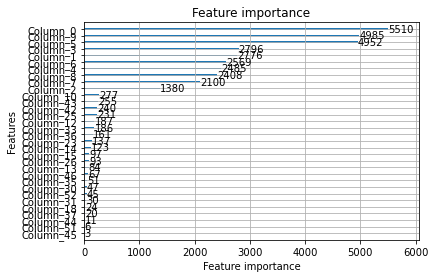

In [45]:
# 绘制特征的相对重要性
lgb.plot_importance(model)
plt.show()

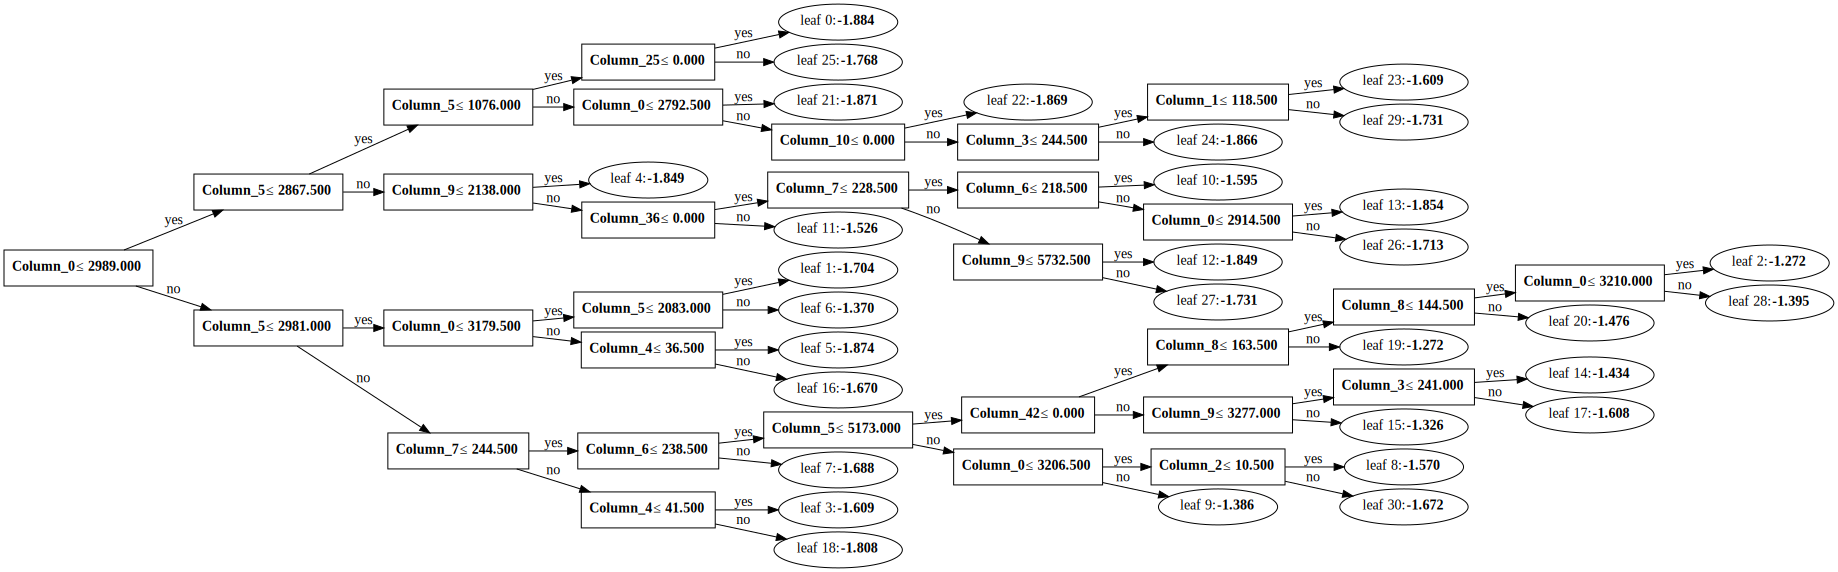

In [46]:
# 可视化lgb分割过程
img = lgb.create_tree_digraph(model)
img

In [47]:
# 数据类型为graphviz.dot.Digraph
type(img)

graphviz.dot.Digraph

In [48]:
# 图保存
# 可对img_view.gv中的数据进行解析
img.view(filename="img_view.gv")

'img_view.gv.pdf'